In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

import wandb

In [2]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy"
X_raw = np.load(path).swapaxes(1,2) 
X, _ = pre_processing(X_raw, soft_normalize='max', center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)    

# np.save('X_softNormMax_centerFalse.npy', X)
# np.save('A_softNormMax_centerFalse.npy', A)

In [3]:
l = 2
K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X[k], l = l)
K_A_X = jnp.array(K_A_X)
K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [4]:
def get_loss_fig(ls_loss, ls_S_ratio):
    plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.plot(ls_loss)
    plt.grid()
    plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
    plt.gca().spines[['top','right']].set_visible(False)
    plt.subplot(212)
    plt.plot(ls_S_ratio)
    plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
    plt.gca().spines[['top','right']].set_visible(False)
    plt.grid()
    plt.subplots_adjust(hspace=0.5)

Iteration 0, S: 3.0502062031700916e-07, S_ratio: 0.1743711233139038
Iteration 10, S: 8.125787644530647e-06, S_ratio: 0.40043920278549194
Iteration 20, S: 0.00020307507656980306, S_ratio: 0.33212965726852417
Iteration 30, S: 0.008924687281250954, S_ratio: 0.43400055170059204
Iteration 40, S: 0.020959943532943726, S_ratio: 0.48742982745170593
Iteration 50, S: 0.0460338294506073, S_ratio: 0.3924311101436615
Iteration 60, S: 0.06340348720550537, S_ratio: 0.46779870986938477
Iteration 70, S: 0.06387042254209518, S_ratio: 0.5321168899536133
Iteration 80, S: 0.06687399744987488, S_ratio: 0.46372145414352417
Iteration 90, S: 0.07876510173082352, S_ratio: 0.534479022026062
Iteration 100, S: 0.0939047709107399, S_ratio: 0.5065690875053406
Iteration 110, S: 0.07829093188047409, S_ratio: 0.44525477290153503
Iteration 120, S: 0.09236893057823181, S_ratio: 0.4976222515106201
Iteration 130, S: 0.0859098806977272, S_ratio: 0.4840925633907318
Iteration 140, S: 0.11675473302602768, S_ratio: 0.4987351894

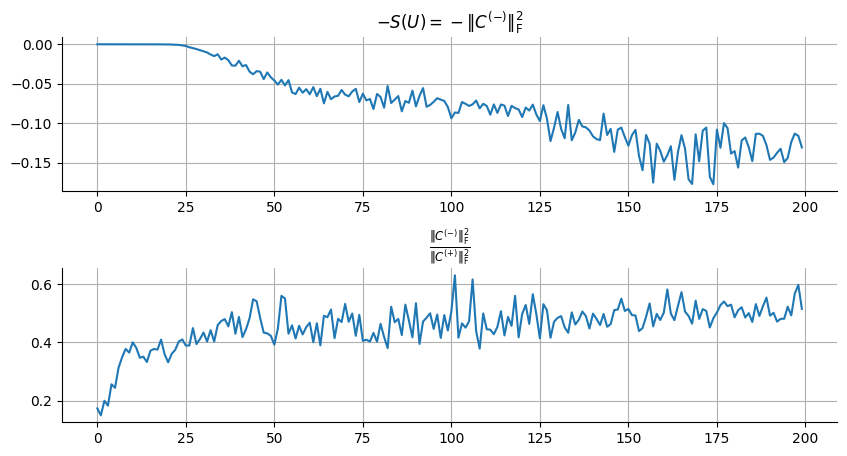

In [7]:
d = 3

wandb.init(project="SCA-project-kernel", name="cpu_local", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 200, learning_rate= 0.1, d=d )
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio)

Text(0.5, 0.92, '0.44827783')

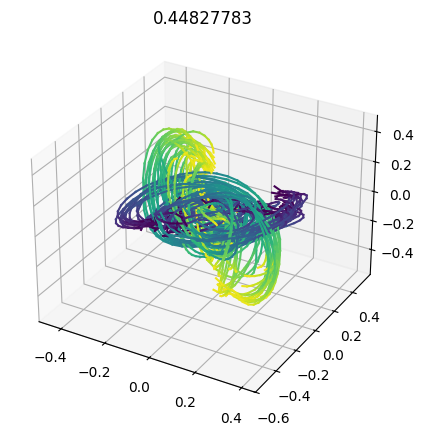

In [8]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde)
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)

projection, _ = pre_processing(projection, pca=False, soft_normalize=None)
plot_3D(projection)
plt.title(compute_S_all_pairs(jnp.array(projection)))

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/alpha_tilde_', alpha_tilde)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/projection_', projection)

Iteration 0, S: 0.17994193732738495, S_ratio: 0.12430968135595322
Iteration 10, S: 0.6476401090621948, S_ratio: 0.39737337827682495
Iteration 20, S: 2.342599868774414, S_ratio: 0.48688527941703796
Iteration 30, S: 3.7184858322143555, S_ratio: 0.431841105222702
Iteration 40, S: 3.713768243789673, S_ratio: 0.4281855523586273
Iteration 50, S: 4.5214667320251465, S_ratio: 0.3595302999019623
Iteration 60, S: 5.70434045791626, S_ratio: 0.35171881318092346
Iteration 70, S: 5.781398296356201, S_ratio: 0.361596941947937
Iteration 80, S: 5.606456279754639, S_ratio: 0.3582090437412262
Iteration 90, S: 6.2871785163879395, S_ratio: 0.3711410164833069


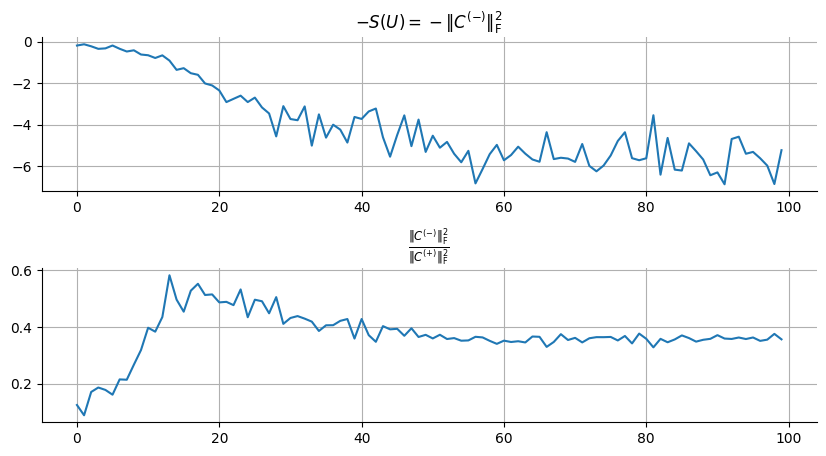

In [10]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy" #/20 ms/
from linear_sca import *
wandb.init(project="SCA-project-MC_Maze", name=f"d={d}", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(pre_processing(X_raw, soft_normalize='max')[0],iterations= 100, learning_rate= 0.1, d=d ) 
wandb.finish()
get_loss_fig(ls_loss, ls_S_ratio)

Text(0.5, 0.92, '0.35716167')

<Figure size 640x480 with 0 Axes>

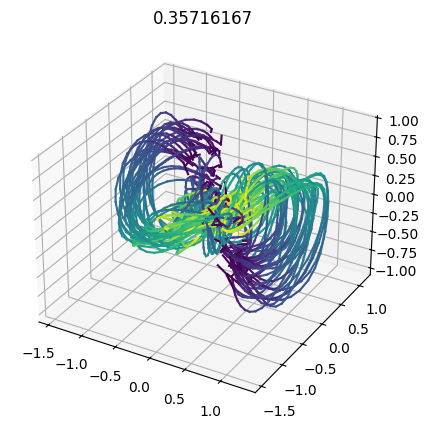

In [11]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, pre_processing(X_raw, soft_normalize='max')[0])
plt.figure()
plot_3D(Y)
plt.title(compute_S_all_pairs(jnp.array(Y)))

# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/U', U)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/Y', Y)

In [13]:
p = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/kernel/projection_3d_l2.0.npy")
p, _ = pre_processing(p, pca=False, soft_normalize=None)

hand_vel = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_eval_behaviour_grouped.npy").swapaxes(1,2)

split = 10
lag = 5
X_train = p[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
X_test = p[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)

X_train_linear = Y[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
X_test_linear = Y[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)

y_train = hand_vel[split:,:,lag:].swapaxes(1,2).reshape(-1, hand_vel.shape[1])
y_test = hand_vel[:split,:,lag:].swapaxes(1,2).reshape(-1, hand_vel.shape[1])

print( get_reg(X_train,y_train,X_test, y_test) )
print( get_reg(X_train_linear,y_train,X_test_linear, y_test) )

0.1457563612918178
0.3538495455933722


ENDS HERE 

In [ ]:

K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_identity(A, X[k])
K_A_X = jnp.array(K_A_X)
K_A_A = jnp.array(K_X_Y_identity(A, A))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

from kernel_sca import *
wandb.init(project="SCA-project-kernel", name="cpu_local", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 500, learning_rate= 0.01, d=d )
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio)

alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde)
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection_linear = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)

plot_3D(projection_linear)
plt.title(compute_S_all_pairs(jnp.array(projection_linear)))

np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/alpha_tilde_linear', alpha_tilde)
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/run 2 comp linear/projection_linear', projection_linear)

In [ ]:

X_train_link = projection_linear[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
X_test_link = projection_linear[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
print( get_reg(X_train_link,y_train,X_test_link, y_test) )

In [ ]:
#projection_load = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_26_6_2024/kernel/projection_3d_l1.5.npy')
#projection_load, _ = pre_processing(projection_load, pca=False, soft_normalize=None)